In [25]:
using ITensors
# using ITensorNetworks
using Observers
using Printf: Format, format
using Printf
using TupleTools
using JLD
using YAML
using HDF5
import Random

push!(LOAD_PATH,pwd())
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")


Nspec, Nsites, Nbonds, Nsweep, e_cutoff, 
		SVD_error, gstart, delta_g, Ng,
        mbond, pairs, evod, angle, Estrength, 
		Nstates, output_filename, parity_symmetry_type,
		inversion_symmetry_type = get_input_data("input_quick_DMRG.yml"; default_filename="test")

###{tdvp_filename}.h5 will be where the data is stored (written to on the fly while propagating every 5th sweep by default)
###ToDo: we might want to parse the name for that file from input

#Calculate kinetic matrix and x operator#
Ttmp = kinetic(Nspec)
Xtmp = Xoperator(Nspec)
Ytmp = Yoperator(Nspec)
Uptmp = Upoperator(Nspec)
Downtmp = Downoperator(Nspec)

use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

if evod == "dvr"
	symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = dvr_symmetric_basis
	elseif use_inversion_symmetry
		symmetry = dvr_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = dvr_rotation_symmetry
	end

	# define basis
	tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
	global T = tmp1
	global X = tmp2
	global Y = tmp3
end
if evod == "m"
    symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
	elseif use_inversion_symmetry
		symmetry = m_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = parity_symmetry
	end


	# define basis
	global T = symmetry(Ttmp)
	global X = symmetry(Xtmp)
	global Y = symmetry(Ytmp)
	global Up = symmetry(Uptmp)
	global Down = symmetry(Downtmp)
end


Nspec=size(T,1)

include("operators.jl")
include("observer.jl")

sites = siteinds("PlaRotor",Nsites;basis=evod,dim=Nspec, conserve_parity=use_parity_symmetry, conserve_inversion_symmetry=use_inversion_symmetry)

Random.seed!(1234)
psi = generate_initial_state(sites; parity_symmetry_type, inversion_symmetry_type)
H = create_Hamiltonian(gstart, sites, pairs; Estrength=0,angle=0, evod=evod)

MPO
[1] ((dim=4|id=894|"Link,l=1"), (dim=8|id=946|"PlaRotor,Site,n=1")', (dim=8|id=946|"PlaRotor,Site,n=1"))
[2] ((dim=4|id=894|"Link,l=1"), (dim=4|id=761|"Link,l=2"), (dim=8|id=178|"PlaRotor,Site,n=2")', (dim=8|id=178|"PlaRotor,Site,n=2"))
[3] ((dim=4|id=761|"Link,l=2"), (dim=4|id=628|"Link,l=3"), (dim=8|id=10|"PlaRotor,Site,n=3")', (dim=8|id=10|"PlaRotor,Site,n=3"))
[4] ((dim=4|id=628|"Link,l=3"), (dim=4|id=705|"Link,l=4"), (dim=8|id=650|"PlaRotor,Site,n=4")', (dim=8|id=650|"PlaRotor,Site,n=4"))
[5] ((dim=4|id=705|"Link,l=4"), (dim=8|id=849|"PlaRotor,Site,n=5")', (dim=8|id=849|"PlaRotor,Site,n=5"))


In [18]:
function find_mapping(mat)
    mapping = []
    rows = size(mat)[2]
    for i=1:rows
        index = argmax(abs.(mat[:,i]))
        if abs(mat[index, i]) < 0.3
            push!(mapping, nothing)
        else
            push!(mapping, index)
        end
    end
    return mapping
end


sweeps = Sweeps(30)
maxdim!(sweeps,20)
setcutoff!(sweeps, 1e-10)

excitation_number = 20
Tij = zeros(excitation_number, excitation_number)
previous_eigenstates = MPS[]
prev_x = nothing
energies = []
g_values = []
connection = []


Hij = zeros(excitation_number, excitation_number)
Sij = zeros(excitation_number, excitation_number) # we want H x = lambda S x
tmp = zeros(excitation_number, excitation_number)
energy_eigenstates = MPS[]
for g=[0.4:0.05:0.6]
    H = create_Hamiltonian(g, sites, Nsecond)


    push!(g_values, g)
    # finding excited state with DMRG
    for i in 1:excitation_number
        energy, ψ = dmrg(H,energy_eigenstates, psi, sweeps;outputlevel=0, weight=30)
        push!(energy_eigenstates, ψ)
    end
    # compute <i|H|j> and <i|j>
    for i in 1:excitation_number
        for j in 1:excitation_number
            Hij[i,j] = inner(energy_eigenstates[i], apply(H, energy_eigenstates[j]))
            Sij[i,j] = inner(energy_eigenstates[i], energy_eigenstates[j])
        end
    end
    # compute generalized eigenvalue problem to rediagonalize
    F = eigen(Hij, Sij)
    push!(energies, F.values)

    # comparing new eigenstates with previous to see which they map to
    if length(previous_eigenstates) > 0
        for i in 1:excitation_number
            for j in 1:excitation_number
                Tij[i,j] = inner(energy_eigenstates[i], previous_eigenstates[j])
            end
        end
        tmp = F.vectors

        push!(connection, find_mapping(F.vectors' * Tij *prev_x))
    else
        push!(connection, nothing)
    end
    prev_x = F.vectors
    previous_eigenstates = copy(energy_eigenstates)
    break
end
connection = connection[2:end]
data = hcat(energies...)'

1×20 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.515499  -0.175548  0.177155  …  1.01132  1.08645  1.12556  1.20044

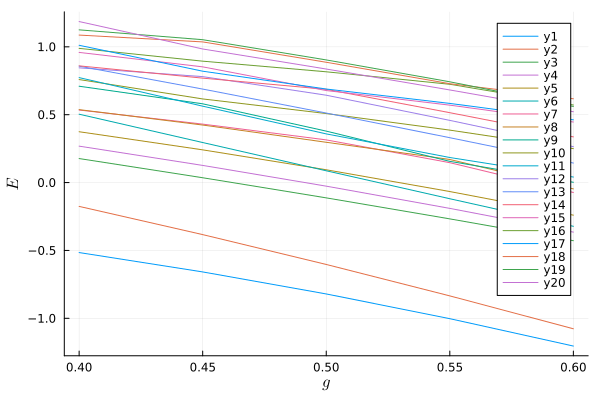

In [10]:
using Plots
using LaTeXStrings

p = plot(xlabel=L"g", ylabel=L"E")
data = hcat(energies...)'
for i = 1:size(data)[2]
    y = [data[1,i]]
    index = i
    for j in 1:length(connection)
        index = findfirst(==(index), connection[j])
        if isnothing(index)
            break
        end
        push!(y, data[1+j, index])
    end
    plot!(p, g_values[1:length(y)], y)
    println()
end
display(p)

In [24]:
using ITensors.HDF5

In [13]:
using JLD
save("../output_data/DMRG_data.jld", "energies", data, "connections", 
    connection, "N", Nsites,"mmax", mmax, "bond_dim", get_maxdims(sweeps))

In [34]:
using Printf
f = h5open(@sprintf("../output_data/DMRG_runs/DMRG_g=%s.jld", "TEST"),"w")
for i in 1:20
    write(f, string("energy_eigenstates/", i), energy_eigenstates[i])
end
write(f,"N", Nsites)
write(f,"mmax", mmax)
write(f, "bond_dim", get_maxdims(sweeps))
close(f)

In [41]:
f = h5open(raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\DMRG_runs\DMRG_g=0.30.jld", "r")
mps = read(f, "energy_eigenstates/1", MPS)
close(f)
println(mps)

MPS
[1] ((dim=11|id=143|"PlaRotor,Site,n=1"), (dim=7|id=48|"Link,l=1"))
[2] ((dim=7|id=48|"Link,l=1"), (dim=11|id=912|"PlaRotor,Site,n=2"), (dim=15|id=86|"Link,l=2"))
[3] ((dim=15|id=86|"Link,l=2"), (dim=11|id=614|"PlaRotor,Site,n=3"), (dim=15|id=455|"Link,l=3"))
[4] ((dim=15|id=455|"Link,l=3"), (dim=11|id=286|"PlaRotor,Site,n=4"), (dim=15|id=413|"Link,l=4"))
[5] ((dim=15|id=413|"Link,l=4"), (dim=11|id=375|"PlaRotor,Site,n=5"), (dim=7|id=370|"Link,l=5"))
[6] ((dim=7|id=370|"Link,l=5"), (dim=11|id=886|"PlaRotor,Site,n=6"))



# Two site operators

In [1]:
using ITensors
# using ITensorNetworks
using Observers
using Printf: Format, format
using Printf
using TupleTools
using JLD
using YAML
using HDF5
import Random

push!(LOAD_PATH,pwd())
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")


Nspec, Nsites, Nbonds, Nsweep, e_cutoff, 
		SVD_error, gstart, delta_g, Ng,
        mbond, pairs, evod, angle, Estrength, 
		Nstates, output_filename, parity_symmetry_type,
		inversion_symmetry_type = get_input_data("input_quick.yml"; default_filename="test")

gstart = 1
Nsites = 100
evod = "m"
parity_symmetry_type = "even"
inversion_symmetry_type = "even"
Nspec = 9
Nsweep= 10
###{tdvp_filename}.h5 will be where the data is stored (written to on the fly while propagating every 5th sweep by default)
###ToDo: we might want to parse the name for that file from input

#Calculate kinetic matrix and x operator#
Ttmp = kinetic(Nspec)
Xtmp = Xoperator(Nspec)
Ytmp = Yoperator(Nspec)
Uptmp = Upoperator(Nspec)
Downtmp = Downoperator(Nspec)

use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

if evod == "dvr"
	symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = dvr_symmetric_basis
	elseif use_inversion_symmetry
		symmetry = dvr_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = dvr_rotation_symmetry
	end

	# define basis
	tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
	global T = tmp1
	global X = tmp2
	global Y = tmp3
end
if evod == "m"
    symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
	elseif use_inversion_symmetry
		symmetry = m_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = parity_symmetry
	end

	# define basis
	global T = symmetry(Ttmp)
	global X = symmetry(Xtmp)
	global Y = symmetry(Ytmp)
	global Up = symmetry(Uptmp)
	global Down = symmetry(Downtmp)
end


Nspec=size(T,1)

include("operators.jl")
include("observer.jl")

sites = siteinds("PlaRotor",Nsites;basis=evod, dim=Nspec, conserve_parity=use_parity_symmetry, conserve_inversion_symmetry=use_inversion_symmetry)

Random.seed!(1234)
psi = generate_initial_state(sites; parity_symmetry_type, inversion_symmetry_type)
# psi = MPS(sites, [1 for i in 1:Nsites])


sweeps = Sweeps(Nsweep)
maxdim!(sweeps,10,10,10,10,10,10,10,10,10,10,10,10,10,10,20,20,20,20,20,20,20,30,30,30,30,30, 30,30,30,30,30,30,30, 30,30)
setcutoff!(sweeps, e_cutoff)

g = gstart
H = create_Hamiltonian(g, sites, "nearest"; evod=evod)
energy_eigenstates = MPS[]


filename = format(Format(output_filename), g, Nsites, parity_symmetry_type)
println(filename)
# h5open(filename, "w") do file
# 	write(file,"N", Nsites)
# 	write(file,"Nspec", Nspec)
# 	write(file,"g", g)
# 	write(file, "bond_dim", get_maxdims(sweeps))
# 	write(file, "parity", parity_symmetry_type)
# 	write(file, "basis", evod)
# end


# finding excited state with DMRG
energies = []
for i in 1:3
    energy, ψ = dmrg(H,energy_eigenstates, psi, sweeps;outputlevel=1, weight=30)
    println(energy)
    push!(energies, energy)
	push!(energy_eigenstates, ψ)
	println("Excitation: ", i)

	# h5open(filename, "r+") do file
	# 	write(file, string("energy_eigenstates/", i), energy_eigenstates[i])
	# end
end


../output_data/DMRG_runs/DMRG_g=1.00_N=100_parity=even.jld
After sweep 1 energy=148.8140706816361  maxlinkdim=10 maxerr=4.71E-03 time=30.835
After sweep 2 energy=-58.458388933223205  maxlinkdim=10 maxerr=1.63E-03 time=4.802
After sweep 3 energy=-71.55522803568347  maxlinkdim=10 maxerr=7.54E-05 time=4.622
After sweep 4 energy=-73.1889194307341  maxlinkdim=10 maxerr=1.10E-05 time=4.857
After sweep 5 energy=-73.38888011372548  maxlinkdim=10 maxerr=4.52E-06 time=4.968
After sweep 6 energy=-73.39802958659841  maxlinkdim=10 maxerr=8.21E-07 time=5.152
After sweep 7 energy=-73.39803868164596  maxlinkdim=10 maxerr=3.58E-07 time=5.002
After sweep 8 energy=-73.39803867038773  maxlinkdim=10 maxerr=3.84E-07 time=4.709
After sweep 9 energy=-73.39803866298048  maxlinkdim=10 maxerr=3.80E-07 time=4.749
After sweep 10 energy=-73.39803866284262  maxlinkdim=10 maxerr=3.79E-07 time=5.500
-73.39803866284262
Excitation: 1
After sweep 1 energy=148.81407068163557  maxlinkdim=10 maxerr=4.71E-03 time=4.886
After

In [18]:
function apply_elementwise_projector(matrix, sites, state; parity="even")
    # elementwise_application(x, i) = i>=2 ?  apply(op(matrix, sites[i]), elementwise_application(x, sites, i-1)) : apply(op(matrix, sites[i]), x)
    tmp = copy(state)
    for i in eachindex(sites)
        # println(i)
        println((@allocated tmp = apply(op(matrix,sites[i]),tmp))/1024^2)
    end
    # @time tmp = elementwise_application(tmp, length(sites))
    if parity == "even"
        return inner(state, (tmp + state)/2)
    end
    return inner(state, (state - tmp)/2)
end

function apply_pairs_projector(matrix, sites, state; parity="even")
    tmp = copy(state)
    for i in 1:length(sites)÷2
        println((@allocated tmp = apply(op(matrix,sites[i], sites[end+1-i]),tmp))/1024^2)
    end
    if parity == "even"
        return inner(state, (tmp + state)/2)
    end
    return inner(state, (state - tmp)/2)
end

function ReflectionOperator(dim)
	arr = zeros(dim*dim,dim*dim)
	for i = 1:dim
		for j = 1:dim
			arr[(i-1)*dim + j,(j-1)*dim+i] = 1
		end
	end
	return arr
end

i = 1
# println(apply_elementwise_projector(symmetry(phiRotationOperator(Nspec)), sites, energy_eigenstates[i]; parity="even"))
println(apply_elementwise_projector(symmetry(MParityOperator(Nspec)), sites, psi; parity="even"))
println(apply_pairs_projector(ReflectionOperator(Nspec), sites, psi; parity="even"))
# println(apply_elementwise_projector(symmetry(MInversionOperator(Nspec)), sites, psi; parity="even"))
# Profile.print()
# println(apply_elementwise_projector(symmetry(phiReflectionOperator(Nspec)), sites, energy_eigenstates[i]; parity="even"))
# println()
# println(energies[i])


# m_(i) = op(m2(Nspec), sites[i])
# m2_(i) = op(m2_flip(Nspec), sites[i])
# new_state = apply(m_(2),apply(m_(1), energy_eigenstates[i]))
# println(apply_pairs_projector(symmetry(ReflectionOperator(Nspec)), sites, new_state; parity="even"))
# println(energies[i]," ", inner(new_state, apply(H, new_state)))
# tmp_H1 = MPO(AutoMPO() + ("X",1), sites)
# # tmp_H2 = MPO(AutoMPO() + ("X",2),sites)
# s = apply(m_(1),apply(m_(2),energy_eigenstates[i]))
# normalize!(s)
# println(inner(s,apply(H,s)))

4.438629150390625
0.230804443359375
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2475738525390625
0.2486114501953125
0.2331695556640625
0.9999999999999967
32.868568420410156
31.41809844970703
37.356834411621094
136.54975128173828
1349.5046463012695
14922.24993133545
140035.9866256714


OutOfMemoryError: OutOfMemoryError()

In [13]:
@allocated ReflectionOperator(Nspec)

52592

In [67]:
using ITensors
# using ITensorNetworks
using Observers
using Printf: Format, format
using Printf
using TupleTools
using JLD
using YAML
using HDF5
import Random
using IterTools
using LinearAlgebra

push!(LOAD_PATH,pwd())
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")

function apply_elementwise_projector(matrix, sites, state; parity="even")
    tmp = copy(state)
    for i in eachindex(sites)
        tmp = apply(op(matrix,sites[i]),state)
    end
    if parity == "even"
        return inner(state, (tmp + state)/2)
    end
    return inner(state, (tmp - state)/2)
end
function apply_pairs_projector(matrix, sites, state; parity="even")
    tmp = copy(state)
    for i in eachindex(sites)
        tmp = apply(op(matrix,sites[i], sites[length(sites)+1-i]),state)
    end
    if parity == "even"
        return inner(state, (tmp + state)/2)
    end
    return inner(state, (tmp - state)/2)
end

function get_mps_list(path)
    mps_list = []
    h5open(path, "r") do file   
        for i = 1:20
            println(i)
            try
                mps = read(file, @sprintf("energy_eigenstates/%d", i), MPS)
                push!(mps_list, mps)
            catch LoadError
                break
            end
        end
    end    
    return mps_list 
end


function compute_states(path, filename, past_mps_list, past_vectors; parity_symmetry_type="even", dim=11, evod="m")
    path = joinpath(path, filename)
    
    use_parity_symmetry = (parity_symmetry_type == "even" || parity_symmetry_type == "odd")
    if use_parity_symmetry
        symmetry=parity_symmetry
    else
        symmetry=trivial_symmetry
    end

    Ttmp = kinetic(dim)
    Xtmp = Xoperator(dim)
    Ytmp = Yoperator(dim)
    Uptmp = Upoperator(dim)
    Downtmp = Downoperator(dim)
    
    #Define basis#
    if evod == "dvr"
        tmp1,tmp2,tmp3 = symmetry.(exp_dvr(dim))
        global T = symmetry(tmp1)
        global X = symmetry(tmp2)
        global Y = symmetry(tmp3)
    
        global Nspec=size(T,1)
    else 
        global T = symmetry(Ttmp)
        global X = symmetry(Xtmp)
        global Y = symmetry(Ytmp)
        global Up = symmetry(Uptmp)
        global Down = symmetry(Downtmp)
    
        global Nspec=size(T,1)
    end

    #Define basis#
    mInvert = symmetry(MInversionOperator(dim))
    refop = ReflectionOperator(dim)

    # reading the mps to an array
    println("Getting MPS")
    mps_list = get_mps_list(path)

    # for (i, mps) in enumerate(mps_list)
    #     println(i)
    #     println(apply_elementwise_projector(mInvert, sites, mps))
    #     println(apply_pairs_projector(refop, sites, mps))
    # end

    g = parse(Float64, split(filename, "_")[2][3:end])
    sites = siteinds(mps_list[1])
    H = create_Hamiltonian(g, sites, "nearest")

    Hij = zeros((length(mps_list), length(mps_list)))
    Sij = zeros((length(mps_list), length(mps_list))) # we want H x = lambda S x

    println("Computing H and S")
    for (i, mps1) in enumerate(mps_list)
        for (j,mps2) in enumerate(mps_list)
            Sij[i,j] = inner(mps1, mps2)
            Hij[i,j] = inner(mps1, apply(H,mps2))
        end
        println(i)
    end
    println("Computing eigenvalues")
    F = eigen(Hij, Sij)
    energy_levels = F.values
    eigen_vectors = F.vectors ./ sqrt.(diag(F.vectors' * F.vectors)') # normalize

    println("Computing overlap")
    overlap = nothing
    if !isnothing(past_mps_list)
        overlap = zeros((length(mps_list), length(past_mps_list)))
        for (i, mps1) in enumerate(mps_list)
            for (j,mps2) in enumerate(past_mps_list)
                overlap[i,j] = inner(mps1, mps2)
            end
        end

        overlap = eigen_vectors' * overlap * past_vectors # adjustment may not be necessary depending on DMRG accuracy
    end

    println("Computing parity")
    even_m_parity = [apply_elementwise_projector(mInvert, sites, mps; parity="even") for mps in mps_list]
    # even_reflection_parity = [apply_pairs_projector(refop, sites, mps) for mps in mps_list] # too computationally extensive

    return g, mps_list, overlap, energy_levels, even_m_parity, eigen_vectors
end


path = raw"/home/jkambulo/projects/def-pnroy/jkambulo/dmrg/output_data/DMRG_runs2"
files = readdir(path)
even_files = sort(filter(x->occursin("even", x), files),by=x->parse(Float64, split(x, "_")[2][3:end]))
odd_files = sort(filter(x->occursin("odd", x), files), by=x->parse(Float64, split(x, "_")[2][3:end]))


Nspec = nothing
Nsites = nothing
evod = nothing
h5open(joinpath(path, even_files[1]), "r") do f1
    # write(file, string("energy_eigenstates/", i), energy_eigenstates[i])
    global Nsites = read(f1, "N")
    global Nspec = read(f1, "Nspec")
    global evod = read(f1, "basis")
end

include("operators.jl")
include("observer.jl")


# println(even_files)
# println(odd_files)
overlap_threshold = 0.4
curves = Dict() # vector of vector with two elements. First is g values, second is y value
_past_mps_list = nothing
_past_vectors = nothing
num_completed_curves = 0
println(path)
for filename in even_files
    println(filename)
    g, _past_mps_list, overlap, energy_levels, even_m_parity, _past_vectors = compute_states(path, filename, _past_mps_list, _past_vectors; parity_symmetry_type="even", dim=Nspec, evod=evod)
    # h5open(@sprintf("C:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\dmrg\\output_data\\DMRG_runs\\processed_%s", filename), "w") do file
    #     if !isnothing(overlap)
    #         write(file, "overlap", overlap)
    #     end
    #     write(file, "energy_levels", energy_levels)  
    #     write(file, "even_m_parity", even_m_parity)  
    #     write(file, "past_vectors", _past_vectors)  
    # end
    
    global _past_mps_list, _past_vectors = _past_mps_list, _past_vectors
    # adjusting curves based on overlap
    if isnothing(overlap)
        for (i,(energy, parity)) in enumerate(zip(energy_levels, even_m_parity))
            curves[i] = [[g], [energy], [parity]]
        end
    else
        overlap = abs.(overlap).^2
        # show(IOContext(stdout, :limit=>false), MIME"text/plain"(), overlap)
        new_size, old_size = size(overlap)
        used_indices = Set()
        mapping = Dict()
        for i=1:old_size
            max_index = argmax(overlap[:,i])
            if overlap[max_index, i] >= overlap_threshold && !(max_index in used_indices)
                mapping[i] = max_index
                push!(used_indices, max_index)
            else
                mapping[i] = string("curve", num_completed_curves)
                global num_completed_curves += 1
            end
        end
        global curves = Dict(get!(mapping, key, key)=>val for (key, val) in curves)
        for (i, (energy, parity)) in enumerate(zip(energy_levels, even_m_parity))
            if !(i in used_indices)
                curves[i] = [[g], [energy], [parity]]
            else
                push!(curves[i][1],g)
                push!(curves[i][2],energy)
                push!(curves[i][3],parity)
            end
        end

    end
end
println(curves)
# h5open(raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\DMRG_runs\mydata.h5", "w") do file
#     write(file, "curves", curves)  # alternatively, say "@write file A"
# end

C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\DMRG_runs
DMRG_g=0.60_N=3_parity=even.jld
Getting MPS
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Computing H and S
Computing eigenvalues
Computing overlap
Computing parity
DMRG_g=1.00_N=3_parity=even.jld
Getting MPS
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Computing H and S
Computing eigenvalues
Computing overlap
Computing parity
DMRG_g=3.00_N=3_parity=even.jld
Getting MPS
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Computing H and S
Computing eigenvalues
Computing overlap
Computing parity
DMRG_g=5.00_N=3_parity=even.jld
Getting MPS
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Computing H and S
Computing eigenvalues
Computing overlap
Computing parity
Dict{Any, Vector{Vector{Float64}}}("curve7" => [[0.6, 1.0], [4.110495962983397, 4.290543550435633], [0.7747910863812515, 0.6845257653738984]], 5 => [[0.6, 1.0, 3.0, 5.0], [1.9116775912485464, 1.7509618169356544, -0.6566621387991354, -4.852664058682719], [0.804455302794

In [20]:
function group_files_in_dir(path)
    files = readdir(path)
    filename_groupings = Dict()
    for file in files
        parity_key = nothing
        inversion_key = nothing
        if occursin("parity=even", file)
            parity_key = "even"
        elseif occursin("parity=odd", file)
            parity_key = "odd"
        else
            parity_key = "none"
        end
    
        if occursin("inversion=even", file)
            inversion_key = "even"
        elseif occursin("inversion=odd", file)
            inversion_key = "odd"
        else
            inversion_key = "none"
        end
    
        if (parity_key, inversion_key) in keys(filename_groupings)
            push!(filename_groupings[(parity_key, inversion_key)], file)
        else
            filename_groupings[(parity_key, inversion_key)] = [file]
        end
    end
    for (key, val) in filename_groupings
        filename_groupings[key] = sort(val, by=x->parse(Float64, split(x, "_")[2][3:end]))
    end
    return filename_groupings
end

group_files_in_dir(raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\DMRG_runs")

Dict{Any, Any} with 1 entry:
  ("even", "none") => ["DMRG_g=0.60_N=3_parity=even.jld", "DMRG_g=1.00_N=3_pari…

# Data processing

In [14]:

function group_files_in_dir(path)
    # groups all files in folder into their symmetries and sorts them by g value
    # requires the naming convention 
    # SOMETHING_g=#_N=#_parity=even_inversion=odd.jld 
    files = readdir(path)
    filename_groupings = Dict()
    for file in files
        parity_key = nothing
        inversion_key = nothing
        if occursin("parity=even", file)
            parity_key = "even"
        elseif occursin("parity=odd", file)
            parity_key = "odd"
        else
            parity_key = "none"
        end
    
        if occursin("inversion=even", file)
            inversion_key = "even"
        elseif occursin("inversion=odd", file)
            inversion_key = "odd"
        else
            inversion_key = "none"
        end
    
        if (parity_key, inversion_key) in keys(filename_groupings)
            push!(filename_groupings[(parity_key, inversion_key)], file)
        else
            filename_groupings[(parity_key, inversion_key)] = [file]
        end
    end
    for (key, val) in filename_groupings
        filename_groupings[key] = sort(val, by=x->parse(Float64, split(x, "_")[4][3:end]))
    end
    return filename_groupings
end


group_files_in_dir (generic function with 1 method)

In [1]:
using HDF5

curves_dict = Dict()
num_completed_curves = 0
overlap_threshold = 0.01
path = raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\processed_data3"

filename_groups = group_files_in_dir(path)

for ((parity_symmetry, inversion_symmetry), files) in filename_groups
    for filename in files
        h5open(joinpath(path, filename), "r") do file
            dict_key(x) = "$parity_symmetry-$inversion_symmetry-$x"

            overlap = nothing
            try
                overlap = read(file, "overlap")
            catch
            end

            g = read(file, "g")  
            energy_levels = read(file, "energy_levels")  
            even_m_parity = read(file, "even_m_parity")  
            past_vectors = read(file, "past_vectors")  
            if isnothing(overlap)
                for (i,(energy, parity)) in enumerate(zip(energy_levels, even_m_parity))
                    curves_dict[dict_key(i)] = [[g], [energy], [parity]]
                end
            else
                overlap = abs.(overlap).^2
                # display(overlap)
                # show(IOContext(stdout, :limit=>false), MIME"text/plain"(), overlap)
                new_size, old_size = size(overlap)
                used_indices = Set()
                mapping = Dict()
                for i=1:old_size
                    max_index = argmax(overlap[:,i])
                    if overlap[max_index, i] >= overlap_threshold && !(max_index in used_indices)
                        mapping[dict_key(i)] = dict_key(max_index)
                        push!(used_indices, dict_key(max_index))
                    else
                        # println(overlap[max_index, i])
                        mapping[dict_key(i)] = dict_key("curve$num_completed_curves")
                        global num_completed_curves += 1
                    end
                end
                global curves_dict = Dict(get!(mapping, key, key)=>val for (key, val) in curves_dict)
                for (i, (energy, parity)) in enumerate(zip(energy_levels, even_m_parity))
                    if !(dict_key(i) in used_indices)
                        curves_dict[dict_key(i)] = [[g], [real.(energy)], [parity]]
                    else
                        push!(curves_dict[dict_key(i)][1],g)
                        push!(curves_dict[dict_key(i)][2],real.(energy))
                        push!(curves_dict[dict_key(i)][3],parity)
                    end
                end

            end
        end
    end
end

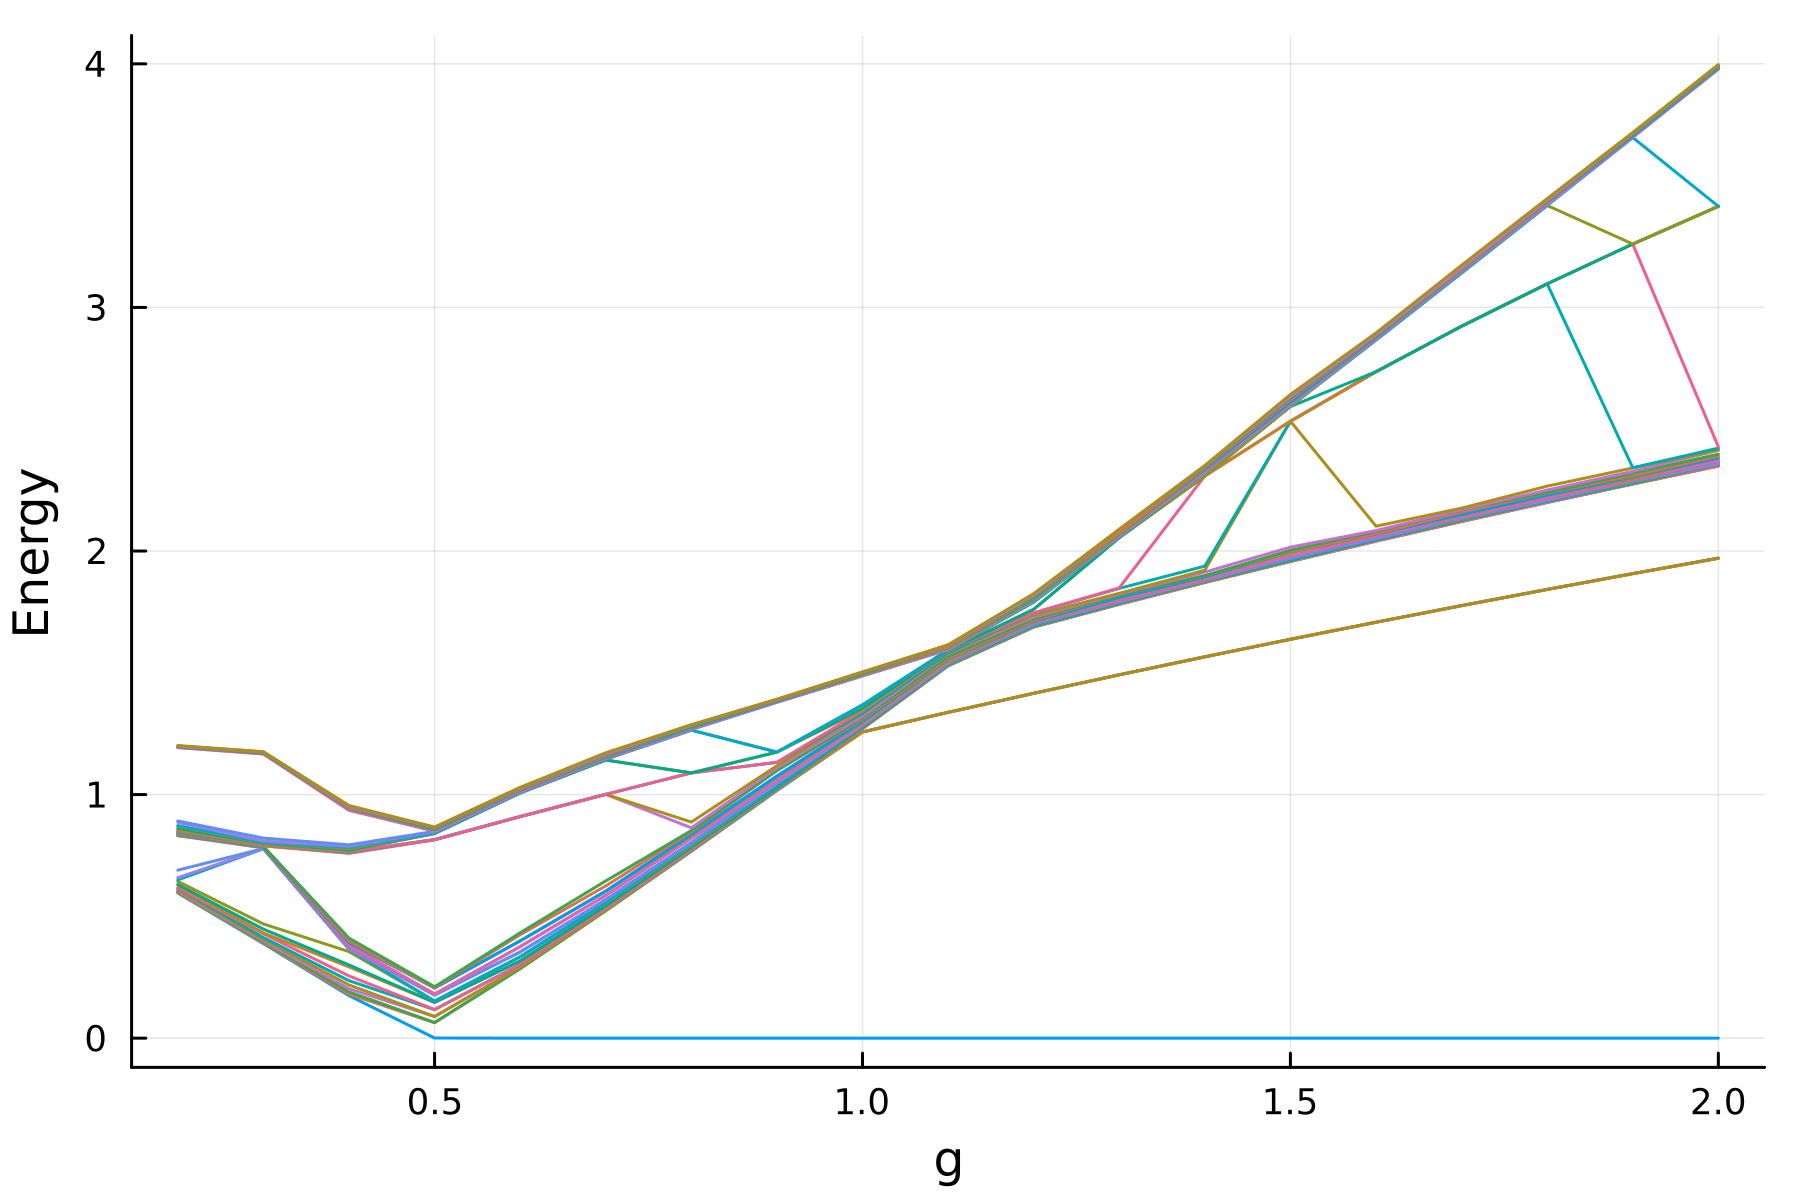

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\dmrg\\dmrg\\2024_07_10_energy_level_differences_all.png"

In [99]:
using Plots

# energy differences 
path = raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\processed_data3"

filename_groups = group_files_in_dir(path)
g_values = 0.2:0.1:2
n_energies = 37
energy_diff = zeros(n_energies, length(g_values))
for (i,g) in enumerate(g_values)
    energies = []
    ground_state = nothing
    for ((parity_symmetry, inversion_symmetry), files) in filename_groups
        for filename in files
            if !occursin("g=$g", filename)
                continue
            end
            h5open(joinpath(path, filename), "r") do file
                energy_levels = read(file, "energy_levels")
                global energies = vcat(real.(energies), energy_levels)
            end
        end
    end
    energies = sort(energies)
    ground_energy = energies[1]
# println(energies)


    under_energy_barrier = sum(energies .< -2*(100-1)*g + 8g)
    total = length(energies)
    println(under_energy_barrier/total)
    for k in 1:n_energies
        energy_diff[k,i] = energies[k+1] - energies[1]
    end
end
p = plot(xlabel="g", ylabel="Energy", dpi=300, legend=nothing)
for k in 1:n_energies
    plot!(p, g_values, energy_diff[k,:], label="E$k-E0")
end
plot!(p, g_values, energy_diff[k,:], label="E$k-E0")
display(p)
savefig(p, "2024_07_10_energy_level_differences_all.png")
# println(energies[3] - energies[1])
# println("$under_energy_barrier/$total")
# println(ground_energy)

In [37]:
# generate table of data for lowest energies computed with DMRG and its symmetries
using Printf
path = raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\processed_data3"

filename_groups = group_files_in_dir(path)
g_values = 0.2:0.1:2
n_energies = 37
energy_diff = zeros(n_energies, length(g_values))

g = 1.7
println(raw"\begin{table}[h]")
println(raw"\centering")
println(raw"\begin{tabular}{||c c c||}")
println(raw"\hline")
println("Energy & Parity Symmetry & Inversion Symmetry \\\\")
println(raw"\hline\hline")


energies = nothing
ground_state = nothing
for ((parity_symmetry, inversion_symmetry), files) in filename_groups
    for filename in files
        if !occursin("g=$g", filename)
            continue
        end
        h5open(joinpath(path, filename), "r") do file
            energy_levels = read(file, "energy_levels")
            global energies_to_add = hcat(real.(energy_levels), 
                [parity_symmetry for _ in 1:length(energy_levels)],
                [inversion_symmetry for _ in 1:length(energy_levels)],
            )
        end
        if isnothing(energies)
            global energies = energies_to_add
        else
            global energies = vcat(energies,energies_to_add)
        end
        # println(size(energies))
        # println(size(energies_to_add))
        # println(energies)
        # println(energies_to_add)
        # vcat(energies, energies_to_add)
        # global energies = vcat(real.(energies),energies_to_add)
    end
end
# println(energies)
energies = energies[sortperm(energies[:, 1]), :]
for (energy, parity, inv) in eachrow(energies)[1:10]
    println(@sprintf("%0.4f & %s & %s \\\\", energy, parity, inv))
    println("\\hline")
end
println(raw"\end{tabular}")
println("\\caption{\\(g=$g\\)}")
println(raw"\end{table}")

\begin{table}[h]
\centering
\begin{tabular}{||c c c||}
\hline
Energy & Parity Symmetry & Inversion Symmetry \\
\hline\hline
-169.5396 & even & even \\
\hline
-169.5396 & odd & even \\
\hline
-167.7637 & even & odd \\
\hline
-167.7637 & odd & odd \\
\hline
-167.7637 & even & odd \\
\hline
-167.7637 & odd & odd \\
\hline
-167.4185 & even & odd \\
\hline
-167.4184 & odd & odd \\
\hline
-167.4153 & even & odd \\
\hline
-167.4130 & odd & odd \\
\hline
\end{tabular}
\caption{\(g=1.7\)}
\end{table}


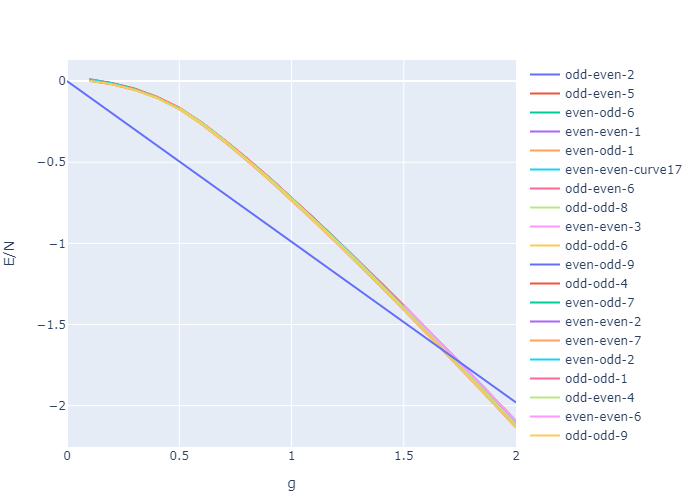

In [104]:
import PlotlyJS
using LaTeXStrings
data = [PlotlyJS.scatter(;x=val[1], y=val[2] ./ 100, mode="lines", name=key) for (key,val) in curves_dict if length(val[1]) > 4]
data = vcat(data, [PlotlyJS.scatter(;x=[0,2],y=[0,-(100-1)/100*2],name="-(N-1)g/N", mode="lines")])
# for (key,val) in curves_dict
#     push!(data, PlotlyJS.scatter(;x=val[1], y=val[2], mode="lines"))
# end
PlotlyJS.plot(data, Layout(
    xaxis_title="g", yaxis_title="E/N"
))

# Testing if orthogonalizing removes the extra energy levels

In [93]:
using ITensors
# using ITensorNetworks
using Observers
using Printf: Format, format
using Printf
using TupleTools
using JLD
using YAML
using HDF5
import Random
using IterTools
using LinearAlgebra

push!(LOAD_PATH,pwd())
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")

function apply_elementwise_projector(matrix, sites, state; parity="even")
    tmp = copy(state)
    for i in eachindex(sites)
        tmp = apply(op(matrix,sites[i]),tmp)
    end
    if parity == "even"
        return inner(state, (tmp + state)/2)
    end
    return inner(state, (tmp - state)/2)
end
function apply_pairs_projector(matrix, sites, state; parity="even")
    tmp = copy(state)
    for i in 1:length(sites)÷2
        tmp = apply(op(matrix,sites[i], sites[end+1-i]),tmp)
    end
    if parity == "even"
        return inner(state, (tmp + state)/2)
    end
    return inner(state, (state - tmp)/2)
end

function get_mps_list(path)
    mps_list = []
    energy = []
    iteration_enegy = []
    energy_uncertainty = []
    h5open(path, "r") do file   
        for i = 1:20
            println(i)
            evod = read(file, "basis")
            Nspec = read(file, "Nspec")
            try
                mps = read(file, "energy_eigenstates/$i", MPS)
                push!(energy,read(file, "energy/$i"))
                push!(energy_uncertainty,read(file, "Delta H/$i"))
                push!(iteration_enegy,read(file, "iteration_energy/$i"))
                push!(mps_list, mps)
            catch LoadError
                println("That's all folks")
                break
            end
        end
    end    
    return mps_list, energy, iteration_enegy, energy_uncertainty
end


function compute_states(path, filename, past_mps_list, past_vectors; parity_symmetry_type="even",inversion_symmetry_type="even", dim=11, evod="m")
    path = joinpath(path, filename)

    Ttmp = kinetic(dim)
    Xtmp = Xoperator(dim)
    Ytmp = Yoperator(dim)
    Uptmp = Upoperator(dim)
    Downtmp = Downoperator(dim)
    
    use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
    use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

    #Define basis
    if evod == "dvr"
        symmetry = trivial_symmetry
        if use_inversion_symmetry && use_parity_symmetry
            symmetry = dvr_symmetric_basis
        elseif use_inversion_symmetry
            symmetry = dvr_inversion_symmetry
        elseif use_parity_symmetry
            symmetry = dvr_rotation_symmetry
        end
    
        # define basis
        tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
        global T = tmp1
        global X = tmp2
        global Y = tmp3

        mInvert = symmetry(phiReflectionOperator(dim))
    end
    if evod == "m"
        symmetry = trivial_symmetry
        if use_inversion_symmetry && use_parity_symmetry
            symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
        elseif use_inversion_symmetry
            symmetry = m_inversion_symmetry
        elseif use_parity_symmetry
            symmetry = parity_symmetry
        end
    
        # define basis
        global T = symmetry(Ttmp)
        global X = symmetry(Xtmp)
        global Y = symmetry(Ytmp)
        global Up = symmetry(Uptmp)
        global Down = symmetry(Downtmp)

        mInvert = symmetry(MInversionOperator(dim))
    end
    

    #Define basis#
    
    # refop = ReflectionOperator(dim)

    # reading the mps to an array
    println("Getting MPS")
    mps_list, energy, iteration_enegy, energy_uncertainty = get_mps_list(path)

    # for (i, mps) in enumerate(mps_list)
    #     println(i)
    #     println(apply_elementwise_projector(mInvert, sites, mps))
    #     println(apply_pairs_projector(refop, sites, mps))
    # end

    g = parse(Float64, split(filename, "_")[3][3:end])
    sites = siteinds(mps_list[1])
    H = create_Hamiltonian(g, sites, "nearest")

    Hij = zeros((length(mps_list), length(mps_list)))
    Sij = zeros((length(mps_list), length(mps_list))) # we want H x = lambda S x

    println("Computing H and S")
    for (i, mps1) in enumerate(mps_list)
        for (j,mps2) in enumerate(mps_list)
            Sij[i,j] = inner(mps1, mps2)
            Hij[i,j] = inner(mps1, apply(H,mps2))
        end
    end
    println("Computing eigenvalues")
    F = eigen(Hij, Sij)
    energy_levels = F.values
    # eigen_vectors = F.vectors ./ sqrt.(diag(F.vectors' * F.vectors)') # normalize

    # println("Computing overlap")
    # overlap = nothing
    # if !isnothing(past_mps_list)
    #     overlap = zeros((length(mps_list), length(past_mps_list)))
    #     for (i, mps1) in enumerate(mps_list)
    #         for (j,mps2) in enumerate(past_mps_list)
    #             overlap[i,j] = inner(mps1, mps2)
    #         end
    #     end

    #     overlap = eigen_vectors' * overlap * past_vectors # adjustment may not be necessary depending on DMRG accuracy
    # end

    # println("Computing parity")
    # even_m_parity = [apply_elementwise_projector(mInvert, sites, mps; parity="even") for mps in mps_list]
    # even_reflection_parity = [apply_pairs_projector(refop, sites, mps) for mps in mps_list] # too computationally extensive
    return g, energy_levels, iteration_enegy, energy_uncertainty, Sij, Hij
end

function group_files_in_dir(path)
    # groups all files in folder into their symmetries and sorts them by g value
    # requires the naming convention 
    # SOMETHING_g=#_N=#_parity=even_inversion=odd.jld 
    files = readdir(path)
    filename_groupings = Dict()
    for file in files
        parity_key = nothing
        inversion_key = nothing
        if occursin("parity=even", file)
            parity_key = "even"
        elseif occursin("parity=odd", file)
            parity_key = "odd"
        else
            parity_key = "none"
        end
    
        if occursin("inversion=even", file)
            inversion_key = "even"
        elseif occursin("inversion=odd", file)
            inversion_key = "odd"
        else
            inversion_key = "none"
        end
    
        if (parity_key, inversion_key) in keys(filename_groupings)
            push!(filename_groupings[(parity_key, inversion_key)], file)
        else
            filename_groupings[(parity_key, inversion_key)] = [file]
        end
    end
    for (key, val) in filename_groupings
        filename_groupings[key] = sort(val, by=x->parse(Float64, split(x, "_")[2][3:end]))
    end
    return filename_groupings
end

include("operators.jl")
include("observer.jl")

_, _, _, _, _, 
		_, gstart, _, _,
        _, _, _, _, _, 
		_, _, parity_symmetry_type,
		inversion_symmetry_type = get_input_data("input_quick_DMRG.yml"; default_filename="test")

# path = raw"/home/jkambulo/projects/def-pnroy/jkambulo/dmrg/output_data/DMRG_runs3/"
# # path = raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\DMRG_runs_test"
# filename_groups = group_files_in_dir(path)
files = ["DMRG_Nspec=11_g=1.70_N=10_parity=even_inversion=even.jld"]
path = raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data"

Nspec = nothing
Nsites = nothing
evod = nothing
overlap_threshold = 0.4
curves = Dict() # vector of vector with two elements. First is g values, second is y value
_past_mps_list = nothing
_past_vectors = nothing
num_completed_curves = 0
println(path)

for filename in files
    h5open(joinpath(path, files[1]), "r") do f1
        # write(file, string("energy_eigenstates/", i), energy_eigenstates[i])
        global Nsites = read(f1, "N")
        global Nspec = read(f1, "Nspec")
        global evod = read(f1, "basis")
    end
    # dict_key(x) = "$parity_symmetry-$inversion_symmetry-$x"
    println(filename)
    g, energy_levels, iteration_enegy, 
        energy_uncertainty,Sij, Hij = compute_states(path, filename, _past_mps_list, _past_vectors; 
                                                parity_symmetry_type="even", 
                                                inversion_symmetry_type="even", dim=Nspec, evod=evod)
    println(iteration_enegy)

    # h5open(@sprintf("/home/jkambulo/projects/def-pnroy/jkambulo/dmrg/output_data/processed_data2/processed_data_%s", filename), "w") do file
    #     write(file, "g", g)  
    #     write(file, "energy_levels", energy_levels)  
    #     write(file, "iteration_uncertainty", iteration_uncertainty)
    #     write(file, "energy_uncertainty", energy_uncertainty)
    #     write(file, "Sij", Sij)
    #     write(file, "Hij", Hij)
    # end
    
end


C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data
DMRG_Nspec=11_g=1.70_N=10_parity=even_inversion=even.jld
Getting MPS
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
That's all folks
Computing H and S
Computing eigenvalues


In [114]:
path = raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data"
filename = raw"DMRG_Nspec=11_g=1.70_N=10_parity=even_inversion=even.jld"
g, energy_levels, iteration_energy, 
    energy_uncertainty,Sij, Hij = compute_states(path, filename, _past_mps_list, _past_vectors; 
                                        parity_symmetry_type="even", 
                                        inversion_symmetry_type="even", dim=Nspec, evod=evod)

Getting MPS
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
That's all folks
Computing H and S
Computing eigenvalues


(1.7, [-14.875761154348265, -11.957111834482246, -11.948108684452297, -11.600116124400598, -11.326162496264704, -11.32433035032819, -11.012107036057603, -10.989265656109566, -10.984303763038378, -10.76773374554235, -10.764146928798086, -10.670929892223478, -10.629948171796714, -10.511522520815614, -10.477779516241618], Any[0.01437025513766986, 0.0016689232076776961, 0.003500469563807265, 0.0027290573309867324, 0.003632851125785067, 0.0019020276130439974, 0.0034809115835248454, 0.00383830008295586, 0.003107460622321604, 0.004827985922485788, 0.003526302812234958, 0.0035549822011378893, 0.0019668972737113383, 0.004145698662728435, 0.005037246639048342], Any[[27.047123818162856, -8.66504644386994, -14.238246363088479, -14.82367844990337, -14.874352441184946, -14.87573913242296, -14.875757204122856, -14.875757537339279, -14.875757543802976, -14.875757524703346, -14.875757518824429, -14.875757517484931, -14.875757516983715], [27.048002673347515, -5.8983525209520815, -11.003059279415384, -11

In [120]:
energy_levels

15-element Vector{Float64}:
 -14.875761154348265
 -11.957111834482246
 -11.948108684452297
 -11.600116124400598
 -11.326162496264704
 -11.32433035032819
 -11.012107036057603
 -10.989265656109566
 -10.984303763038378
 -10.76773374554235
 -10.764146928798086
 -10.670929892223478
 -10.629948171796714
 -10.511522520815614
 -10.477779516241618

In [119]:
iteration_energy

15-element Vector{Any}:
 0.01437025513766986
 0.0016689232076776961
 0.003500469563807265
 0.0027290573309867324
 0.003632851125785067
 0.0019020276130439974
 0.0034809115835248454
 0.00383830008295586
 0.003107460622321604
 0.004827985922485788
 0.003526302812234958
 0.0035549822011378893
 0.0019668972737113383
 0.004145698662728435
 0.005037246639048342

In [118]:
[length(x) for x in energy_uncertainty]

15-element Vector{Int64}:
  13
 300
  39
  38
  42
  70
 300
 300
  86
 300
 204
 300
 132
 252
 196

In [117]:
[diff(x)[end] for x in energy_uncertainty]

15-element Vector{Float64}:
  5.012168458051747e-10
 -5.4975419772063105e-9
  2.0906121278585488e-10
 -8.687273123086925e-10
 -9.92073978522967e-10
 -9.913350140777766e-10
 -1.6998882301777485e-9
 -2.1538926215924903e-6
 -8.221547886932967e-10
 -4.50515872607582e-6
 -9.975735792977503e-10
 -1.1816327827318673e-7
  3.8828318338346435e-10
 -9.790852573132725e-10
 -9.372200793222873e-10

In [109]:
Sij

15×15 Matrix{Float64}:
  1.0         -2.00894e-6  -2.88343e-9  …  -7.8792e-8   -2.3004e-5
 -2.00894e-6   1.0          4.11374e-7     -7.98325e-8  -1.15014e-7
 -2.88343e-9   4.11374e-7   1.0             1.16693e-6  -2.51694e-8
 -4.77818e-7  -5.10794e-7   5.58653e-7     -2.068e-7     5.25611e-7
 -5.50689e-9   2.6762e-7   -1.33647e-7     -2.65589e-7  -2.54098e-7
 -4.2223e-6   -6.33569e-8  -8.1225e-9   …   3.55885e-8  -1.32628e-7
  2.24994e-5   8.79966e-8  -8.93371e-8      2.04353e-7   7.25325e-8
  4.65846e-6  -8.36652e-6   3.33535e-6     -1.46931e-7  -7.54374e-7
 -1.56717e-5  -1.14521e-7   6.82608e-8      9.36328e-8   5.64898e-7
  1.30716e-5  -4.4217e-6    3.41762e-7     -1.09937e-7  -4.98529e-7
  5.37817e-6   1.25409e-7  -1.20025e-6  …   1.96041e-7  -2.725e-7
  9.79868e-6   1.549e-6    -2.70283e-6      2.15618e-7  -8.0374e-8
  6.51004e-8  -6.2557e-8   -3.78441e-9     -1.25129e-8  -7.00113e-7
 -7.8792e-8   -7.98325e-8   1.16693e-6      1.0         -2.81882e-7
 -2.3004e-5   -1.15014e-7  -2

In [79]:
using Printf
using HDF5
using ITensors
function get_mps_list(path)
    mps_list = []
    energy = []
    evod = nothing
    Nspec = nothing
    h5open(path, "r") do file   
        for i = 1:20
            println(i)
            evod = read(file, "basis")
            Nspec = read(file, "Nspec")
            try
                mps = read(file, @sprintf("energy_eigenstates/%d", i), MPS)
                push!(energy,read(file, "energy/$i"))
                push!(mps_list, mps)
            catch LoadError
                println("That's all folks")
                break
            end
        end
    end    
    return mps_list, energy, evod, Nspec
end


filename = "DMRG_g=0.90_N=100_parity=odd_inversion=odd.jld"
path = raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\DMRG_runs5"
mps_list, energy, evod, Nspec = get_mps_list(raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\DMRG_g=1.70_N=5_parity=even_inversion=even.jld")
# mps_list = []
# energy_list = []
# for filename in readdir(path)
#     if !occursin("g=1.7",filename)
#         continue
#     end
#     new_mps, energy = get_mps_list(joinpath(path, filename))
#     mps_list = [mps_list; new_mps]
#     energy_list = [energy_list; energy]
# end


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
That's all folks


(Any[MPS
[1] ((dim=9|id=404|"Link,l=1") <Out>
 1: QN(("inv_sym",0,2),("parity",0,2)) => 3
 2: QN(("inv_sym",0,2),("parity",1,2)) => 2
 3: QN(("inv_sym",1,2),("parity",0,2)) => 2
 4: QN(("inv_sym",1,2),("parity",1,2)) => 2, (dim=9|id=970|"PlaRotor,Site,n=1") <Out>
 1: QN(("inv_sym",0,2),("parity",0,2)) => 3
 2: QN(("inv_sym",1,2),("parity",0,2)) => 2
 3: QN(("inv_sym",0,2),("parity",1,2)) => 2
 4: QN(("inv_sym",1,2),("parity",1,2)) => 2)
[2] ((dim=10|id=534|"Link,l=2") <Out>
 1: QN(("inv_sym",0,2),("parity",0,2)) => 3
 2: QN(("inv_sym",0,2),("parity",1,2)) => 3
 3: QN(("inv_sym",1,2),("parity",0,2)) => 2
 4: QN(("inv_sym",1,2),("parity",1,2)) => 2, (dim=9|id=377|"PlaRotor,Site,n=2") <Out>
 1: QN(("inv_sym",0,2),("parity",0,2)) => 3
 2: QN(("inv_sym",1,2),("parity",0,2)) => 2
 3: QN(("inv_sym",0,2),("parity",1,2)) => 2
 4: QN(("inv_sym",1,2),("parity",1,2)) => 2, (dim=9|id=404|"Link,l=1") <In>
 1: QN(("inv_sym",0,2),("parity",0,2)) => 3
 2: QN(("inv_sym",0,2),("parity",1,2)) => 2
 3: QN(

In [81]:

parity_symmetry_type = "even"
inversion_symmetry_type = "odd"
global Nspec
include("operators.jl")
g = 1.7
sites = siteinds(mps_list[1])
Ttmp = kinetic(Nspec)
Xtmp = Xoperator(Nspec)
Ytmp = Yoperator(Nspec)
Uptmp = Upoperator(Nspec)
Downtmp = Downoperator(Nspec)

use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

#Define basis
if evod == "dvr"
    symmetry = trivial_symmetry
    if use_inversion_symmetry && use_parity_symmetry
        symmetry = dvr_symmetric_basis
    elseif use_inversion_symmetry
        symmetry = dvr_inversion_symmetry
    elseif use_parity_symmetry
        symmetry = dvr_rotation_symmetry
    end

    # define basis
    tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
    global T = tmp1
    global X = tmp2
    global Y = tmp3

    mInvert = symmetry(phiReflectionOperator(Nspec))
end
if evod == "m"
    symmetry = trivial_symmetry
    if use_inversion_symmetry && use_parity_symmetry
        symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
    elseif use_inversion_symmetry
        symmetry = m_inversion_symmetry
    elseif use_parity_symmetry
        symmetry = parity_symmetry
    end

    # define basis
    global T = symmetry(Ttmp)
    global X = symmetry(Xtmp)
    global Y = symmetry(Ytmp)
    global Up = symmetry(Uptmp)
    global Down = symmetry(Downtmp)

    mInvert = symmetry(MInversionOperator(Nspec))
end
sites = siteinds(mps_list[1])
H = create_Hamiltonian(g, sites, "nearest")

MPO
[1] ((dim=4|id=66|"Link,l=1") <Out>
 1: QN() => 1
 2: QN(("inv_sym",1,2),("parity",1,2)) => 1
 3: QN(("inv_sym",0,2),("parity",1,2)) => 1
 4: QN(("inv_sym",0,2),("parity",0,2)) => 1, (dim=9|id=970|"PlaRotor,Site,n=1")' <Out>
 1: QN(("inv_sym",0,2),("parity",0,2)) => 3
 2: QN(("inv_sym",1,2),("parity",0,2)) => 2
 3: QN(("inv_sym",0,2),("parity",1,2)) => 2
 4: QN(("inv_sym",1,2),("parity",1,2)) => 2, (dim=9|id=970|"PlaRotor,Site,n=1") <In>
 1: QN(("inv_sym",0,2),("parity",0,2)) => 3
 2: QN(("inv_sym",1,2),("parity",0,2)) => 2
 3: QN(("inv_sym",0,2),("parity",1,2)) => 2
 4: QN(("inv_sym",1,2),("parity",1,2)) => 2)
[2] ((dim=4|id=66|"Link,l=1") <In>
 1: QN() => 1
 2: QN(("inv_sym",1,2),("parity",1,2)) => 1
 3: QN(("inv_sym",0,2),("parity",1,2)) => 1
 4: QN(("inv_sym",0,2),("parity",0,2)) => 1, (dim=4|id=245|"Link,l=2") <Out>
 1: QN() => 1
 2: QN(("inv_sym",1,2),("parity",1,2)) => 1
 3: QN(("inv_sym",0,2),("parity",1,2)) => 1
 4: QN(("inv_sym",0,2),("parity",0,2)) => 1, (dim=9|id=377|"P

In [83]:
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")
include("operators.jl")

parity_symmetry_type = "even"
inversion_symmetry_type = "odd"
global Nspec
include("operators.jl")
g = 1.7

Ttmp = kinetic(Nspec)
Xtmp = Xoperator(Nspec)
Ytmp = Yoperator(Nspec)
Uptmp = Upoperator(Nspec)
Downtmp = Downoperator(Nspec)

use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

#Define basis
if evod == "dvr"
    symmetry = trivial_symmetry
    if use_inversion_symmetry && use_parity_symmetry
        symmetry = dvr_symmetric_basis
    elseif use_inversion_symmetry
        symmetry = dvr_inversion_symmetry
    elseif use_parity_symmetry
        symmetry = dvr_rotation_symmetry
    end

    # define basis
    tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
    global T = tmp1
    global X = tmp2
    global Y = tmp3

    mInvert = symmetry(phiReflectionOperator(Nspec))
end
if evod == "m"
    symmetry = trivial_symmetry
    if use_inversion_symmetry && use_parity_symmetry
        symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
    elseif use_inversion_symmetry
        symmetry = m_inversion_symmetry
    elseif use_parity_symmetry
        symmetry = parity_symmetry
    end

    # define basis
    global T = symmetry(Ttmp)
    global X = symmetry(Xtmp)
    global Y = symmetry(Ytmp)
    global Up = symmetry(Uptmp)
    global Down = symmetry(Downtmp)

    mInvert = symmetry(MInversionOperator(Nspec))
end
sites = siteinds(mps_list[1])
H = create_Hamiltonian(g, sites, "nearest")

Sij = zeros((length(mps_list), length(mps_list))) # we want H x = lambda S x
Hij = zeros((length(mps_list), length(mps_list)))
println("Computing H and S")
for (i, mps1) in enumerate(mps_list)
    for (j,mps2) in enumerate(mps_list)
        Sij[i,j] = inner(mps1, mps2)
        Hij[i,j] = inner(mps1', H, mps2)
    end
end

Computing H and S


In [85]:
show(stdout,"text/plain", Sij)

15×15 Matrix{Float64}:
  1.0          9.50969e-6   1.5313e-5     7.35254e-5   1.46168e-5   4.55071e-5   1.88447e-7  -4.29654e-6  -6.87872e-8   -9.56064e-8    9.63556e-6   4.76237e-7   -1.09245e-5   3.00748e-5  -4.71097e-7
  9.50969e-6   1.0          4.08482e-6    1.92168e-6   1.01013e-6   6.14442e-7  -1.66118e-7  -8.55862e-7  -1.79321e-8   -2.36835e-7   -1.40846e-6  -2.19423e-7   -1.22253e-6  -1.08071e-6   3.6916e-8
  1.5313e-5    4.08482e-6   1.0          -2.02629e-7  -3.55195e-7  -9.6474e-7    4.34441e-5   8.06684e-7   0.000194558   0.000275772   1.04152e-6  -0.000276931   7.29645e-8  -2.366e-6     0.000105086
  7.35254e-5   1.92168e-6  -2.02629e-7    1.0          1.60555e-6  -6.10375e-7  -6.17602e-7  -8.43346e-8   9.13826e-8    1.81386e-8    6.34973e-8  -3.99749e-8    2.22682e-7   2.34301e-8   6.22587e-8
  1.46168e-5   1.01013e-6  -3.55195e-7    1.60555e-6   1.0          1.59149e-7   5.19484e-7   8.57813e-7   7.21609e-8    3.33147e-7   -1.63019e-7   7.29119e-8   -4.47109e-7  -1.7608

In [84]:
show(stdout,"text/plain", Hij)

15×15 Matrix{Float64}:
 -6.28415      -0.000594874  -9.83214e-5   -0.00388185   -0.000765761  -0.00237621  -9.80757e-6   0.000223149   3.43114e-6   4.166e-6    -0.000494109  -2.38189e-5   0.000558296  -0.00153333    2.37749e-5
 -0.000594874  -3.49751       1.8672e-5    -0.000102125  -3.66703e-5   -4.48888e-5   3.02767e-7   4.37635e-5    2.03382e-6   6.97985e-7   6.97435e-5    8.62825e-7   6.00409e-5    5.28718e-5   -3.77526e-7
 -9.83214e-5    1.8672e-5    -3.21719      -1.201e-5      2.04717e-5    5.39675e-6  -0.00225908   1.94099e-6   -0.010071    -0.0142185   -6.72813e-5    0.0141483   -5.21891e-6    0.000108303  -0.00534349
 -0.00388185   -0.000102125  -1.201e-5     -2.79568      -3.77754e-5    5.0214e-6    1.52661e-6   1.42033e-6   -8.30702e-7   4.30108e-7  -5.56182e-7    5.67482e-7  -3.0524e-6     9.26796e-7    2.74058e-7
 -0.000765761  -3.66703e-5    2.04717e-5   -3.77754e-5   -2.39274      -4.68259e-5  -8.93478e-6  -9.73022e-6    1.81043e-7  -9.81493e-8  -4.42178e-7    2.01969e-

In [86]:
using LinearAlgebra

rank(Sij)


15

In [29]:
eigen_vectors

5×5 Matrix{Float64}:
  0.0228202   -0.999739    -3.16821e-6   6.91776e-6   3.43136e-6
 -0.99974     -0.0228352    1.39307e-6  -2.7752e-6   -1.08019e-6
 -1.46829e-6   3.16086e-6  -0.999972     0.00734693  -0.000921224
 -2.93729e-6   6.71861e-6   0.00743464   0.999963     0.00450614
 -1.05671e-6   2.87016e-6  -0.00096367  -0.00439327   0.999989

In [87]:
F = eigen(Hij, Sij)
energy_levels = F.values
eigen_vectors = F.vectors ./ sqrt.(diag(F.vectors' * F.vectors)') # normalize
energy_levels

15-element Vector{Float64}:
 -6.284154666738189
 -3.4975124057651814
 -3.21745009159084
 -2.7956792891696765
 -2.3927406289501705
 -2.211281851237543
 -2.160151853512878
 -1.6575622718605831
 -1.5966334576664383
 -1.4967637192140797
 -1.2846700595147893
 -1.1455504772887797
 -1.1160737955477293
 -0.9841178984816188
 -0.7429046200353445

In [88]:
energy

15-element Vector{Any}:
 -6.2841495885171526
 -3.4975124903222934
 -3.2171925410574165
 -2.795682903780772
 -2.3927407475486646
 -2.211282966812206
 -2.160156258866575
 -1.6575622166141315
 -1.5966901604805486
 -1.496870893944994
 -1.284670079942721
 -1.1456388860411408
 -1.116073975498857
 -0.9841183058405747
 -0.7429152840995954

In [16]:
show(stdout, "text/plain", Sij)

12×12 Matrix{Float64}:
  1.0          7.78367e-10  -3.82907e-10   0.0           0.0          0.0           0.0           0.0           0.0          0.0           0.0          0.0
  7.78368e-10  1.0           3.69575e-9    0.0           0.0          0.0           0.0           0.0           0.0          0.0           0.0          0.0
 -3.82906e-10  3.69575e-9    1.0           0.0           0.0          0.0           0.0           0.0           0.0          0.0           0.0          0.0
  0.0          0.0           0.0           1.0          -7.06333e-8  -3.23121e-23   0.0           0.0           0.0          0.0           0.0          0.0
  0.0          0.0           0.0          -7.06333e-8    1.0          1.98085e-9    0.0           0.0           0.0          0.0           0.0          0.0
  0.0          0.0           0.0          -3.23121e-23   1.98085e-9   1.0           0.0           0.0           0.0          0.0           0.0          0.0
  0.0          0.0           0.0         

# Energy level analysis 2

In [8]:
# generate table of data for lowest energies computed with DMRG and its symmetries
using Printf
using HDF5
using ITensors
path = raw"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\output_data\DMRG_runs4"

g_values = [0.1,0.5,0.9,1.3,1.7]
n_energies = 37
energy_diff = zeros(n_energies, length(g_values))

g = 1.7
println(raw"\begin{table}[h]")
println(raw"\centering")
println(raw"\begin{tabular}{||c c c c||}")
println(raw"\hline")
println(raw"\(\langle H \rangle\) & \(\Delta H\) &Parity Symmetry & Inversion Symmetry \\\\")
println(raw"\hline\hline")


energies = nothing
ground_state = nothing
for filename in readdir(path)
    if !occursin("g=$g", filename)
        continue
    end
    prev_eigenstate = nothing
    h5open(joinpath(path, filename), "r") do file
        parity_symmetry = read(file, "parity")
        inversion_symmetry = read(file, "inversion")
        energy_levels = []
        deltaH = []
        for i = 1:40
            try
                push!(energy_levels, read(file, "energy/$i"))
                push!(deltaH, read(file, "Delta H/$i"))

            catch
                # println(i)
                break
            end
            eigenstate = read(file, "energy_eigenstates/$i", MPS)
            
            if !isnothing(prev_eigenstate)
                println("Inner product: ",inner(eigenstate, prev_eigenstate))
                println(energy_levels[end])

            end
            global prev_eigenstate = eigenstate
        end
    global energies_to_add = hcat(
        real.(energy_levels), 
        real.(deltaH),
        [parity_symmetry for _ in 1:length(energy_levels)],
        [inversion_symmetry for _ in 1:length(energy_levels)],
    )
    end
    if isnothing(energies)
        global energies = energies_to_add
    else
        global energies = vcat(energies,energies_to_add)
    end
    # println(size(energies))
    # println(size(energies_to_add))
    # println(energies)
    # println(energies_to_add)
    # vcat(energies, energies_to_add)
    # global energies = vcat(real.(energies),energies_to_add)
end
# println(energies)
energies = energies[sortperm(energies[:, 1]), :]
# println(energies)
for (energy, energy_uncertainty, parity, inv) in eachrow(energies)[1:10]
    println(@sprintf("%0.4f & %.4f & %s & %s \\\\", energy,energy_uncertainty, parity, inv))
    println("\\hline")
end
println(raw"\end{tabular}")
println("\\caption{\\(g=$g\\)}")
println(raw"\end{table}")

\begin{table}[h]
\centering
\begin{tabular}{||c c c c||}
\hline
\(\langle H \rangle\) & \(\Delta H\) &Parity Symmetry & Inversion Symmetry \\
\hline\hline
Inner product: -1.0315564930030163e-9
-166.6165902584662
Inner product: -1.0508615786843492e-18
-166.61659025846214
Inner product: -2.6346266897016473e-8
-166.3982683991935
Inner product: 1.9014870606250904e-5
-166.38751308665135
Inner product: -4.270500447108988e-49
-167.76374694507842
Inner product: 1.6641049076643712e-8
-167.41845757474704
Inner product: 9.194773981178023e-5
-167.41317341945614
Inner product: -0.00010582636294501359
-167.39914082892196
Inner product: -1.0187085412542298e-9
-166.6165902584623
Inner product: 1.0508738442218697e-18
-166.61659025846603
Inner product: 2.876462722439105e-8
-166.3982718077926
Inner product: -4.207647312771441e-6
-166.38257327768488
Inner product: -1.640349436456801e-49
-167.76374694480802
Inner product: -3.1412410683057965e-8
-167.41845980106984
Inner product: -0.00012112320120542548
-16

# Comparing DVR with VBR

In [7]:
using ITensors
# using ITensorNetworks
using Observers
using Printf: Format, format
using Printf
using TupleTools
using JLD
using YAML
using HDF5
import Random

push!(LOAD_PATH,pwd())
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")

Nspec, Nsites, Nbonds, Nsweep, e_cutoff, 
		SVD_error, gstart, delta_g, Ng,
        mbond, pairs, evod, angle, Estrength, 
		Nstates, output_filename, parity_symmetry_type,
		inversion_symmetry_type = get_input_data("input_quick_DMRG.yml"; default_filename="test")

Ttmp = kinetic(Nspec)
Xtmp = Xoperator(Nspec)
Ytmp = Yoperator(Nspec)
Uptmp = Upoperator(Nspec)
Downtmp = Downoperator(Nspec)

use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

if evod == "dvr"
    symmetry = trivial_symmetry
    if use_inversion_symmetry && use_parity_symmetry
        symmetry = dvr_symmetric_basis
    elseif use_inversion_symmetry
        symmetry = dvr_inversion_symmetry
    elseif use_parity_symmetry
        symmetry = dvr_rotation_symmetry
    end

    # define basis
    tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
    global T = tmp1
    global X = tmp2
    global Y = tmp3
end
if evod == "m"
    symmetry = trivial_symmetry
    if use_inversion_symmetry && use_parity_symmetry
        symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
    elseif use_inversion_symmetry
        symmetry = m_inversion_symmetry
    elseif use_parity_symmetry
        symmetry = parity_symmetry
    end

    # define basis
    global T = symmetry(Ttmp)
    global X = symmetry(Xtmp)
    global Y = symmetry(Ytmp)
    global Up = symmetry(Uptmp)
    global Down = symmetry(Downtmp)
end

include("operators.jl")
include("observer.jl")

sites = siteinds("PlaRotor",Nsites;basis=evod, dim=Nspec, conserve_parity=use_parity_symmetry, conserve_inversion_symmetry=use_inversion_symmetry)
    
function get_energy(gstart, evod, _Nspec;Nsweep=10, parity_symmetry_type = "even", inversion_symmetry_type = "even", Nsites = 3)
    ###{tdvp_filename}.h5 will be where the data is stored (written to on the fly while propagating every 5th sweep by default)
    ###ToDo: we might want to parse the name for that file from input

    #Calculate kinetic matrix and x operator#
    global Nspec = _Nspec
    
    Ttmp = kinetic(Nspec)
    Xtmp = Xoperator(Nspec)
    Ytmp = Yoperator(Nspec)
    Uptmp = Upoperator(Nspec)
    Downtmp = Downoperator(Nspec)

    use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
    use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

    if evod == "dvr"
        symmetry = trivial_symmetry
        if use_inversion_symmetry && use_parity_symmetry
            symmetry = dvr_symmetric_basis
        elseif use_inversion_symmetry
            symmetry = dvr_inversion_symmetry
        elseif use_parity_symmetry
            symmetry = dvr_rotation_symmetry
        end

        # define basis
        tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
        global T = tmp1
        global X = tmp2
        global Y = tmp3
    end
    if evod == "m"
        symmetry = trivial_symmetry
        if use_inversion_symmetry && use_parity_symmetry
            symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
        elseif use_inversion_symmetry
            symmetry = m_inversion_symmetry
        elseif use_parity_symmetry
            symmetry = parity_symmetry
        end

        # define basis
        global T = symmetry(Ttmp)
        global X = symmetry(Xtmp)
        global Y = symmetry(Ytmp)
        global Up = symmetry(Uptmp)
        global Down = symmetry(Downtmp)
    end

    include("operators.jl")
    include("observer.jl")
    
    sites = siteinds("PlaRotor",Nsites;basis=evod, dim=Nspec, conserve_parity=use_parity_symmetry, conserve_inversion_symmetry=use_inversion_symmetry)

    Random.seed!(1234)
    psi = generate_initial_state(sites; parity_symmetry_type, inversion_symmetry_type)
    # psi = MPS(sites, [1 for i in 1:Nsites])


    sweeps = Sweeps(Nsweep)
    maxdim!(sweeps,50)
    setcutoff!(sweeps, e_cutoff)

    g = gstart
    H = create_Hamiltonian(g, sites, "nearest"; evod=evod)

    energy, ψ = dmrg(H, psi, sweeps;outputlevel=0)
    dE = sqrt(abs(inner(ψ, apply(H, apply(H, ψ))) - energy^2))
    return energy, dE
end

using DataFrames, CSV
parity_symmetry_type = "none"
inversion_symmetry_type = "none"
nodenames = ["g", "basis", "Nspec", "parity", "inversion", "Nsweep", "Nsites", "energy", "energy uncertainty"]
df = DataFrame([[] for _ = nodenames] , nodenames)
for (parity_symmetry_type,inversion_symmetry_type) in [("none","none"), ("even", "even")]
    for Nspec in [3,4,9,10]
        for g in [0.01, 0.1,1, 5, 20, 100]
            for evod in ["m", "dvr"]
                for Nsweep in [10,20,50]
                    for Nsites in [3,5,10]
                        try
                            @time energy = get_energy(g, evod, Nspec;Nsweep,parity_symmetry_type,inversion_symmetry_type, Nsites)
                            push!(df, [g, evod, Nspec, parity_symmetry_type, inversion_symmetry_type, Nsweep, Nsites, energy...])
                            @show g, evod, Nspec,Nsweep,parity_symmetry_type,inversion_symmetry_type, Nsites
                        catch
                            continue
                        end
                    end
                end
            end
        end
    end
end
# CSV.write("outputfile3.csv",df)


5-element Vector{Index{Int64}}:
 (dim=8|id=402|"PlaRotor,Site,n=1")
 (dim=8|id=888|"PlaRotor,Site,n=2")
 (dim=8|id=953|"PlaRotor,Site,n=3")
 (dim=8|id=250|"PlaRotor,Site,n=4")
 (dim=8|id=645|"PlaRotor,Site,n=5")

# Spurious eigenvalue testing

In [1]:
using ITensors
# using ITensorNetworks
using Observers
using Printf: Format, format
using Printf
using TupleTools
using JLD
using YAML
using HDF5
import Random

push!(LOAD_PATH,pwd())
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")


Nspec, Nsites, Nbonds, Nsweep, e_cutoff, 
		SVD_error, gstart, delta_g, Ng,
        mbond, pairs, evod, angle, Estrength, 
		Nstates, output_filename, parity_symmetry_type,
		inversion_symmetry_type = get_input_data("input_quick_DMRG.yml"; default_filename="test")

Nsites = 10
###{tdvp_filename}.h5 will be where the data is stored (written to on the fly while propagating every 5th sweep by default)
###ToDo: we might want to parse the name for that file from input

#Calculate kinetic matrix and x operator#
Ttmp = kinetic(Nspec)
Xtmp = Xoperator(Nspec)
Ytmp = Yoperator(Nspec)
Uptmp = Upoperator(Nspec)
Downtmp = Downoperator(Nspec)

use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

if evod == "dvr"
	symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = dvr_symmetric_basis
	elseif use_inversion_symmetry
		symmetry = dvr_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = dvr_rotation_symmetry
	end

	# define basis
	tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
	global T = tmp1
	global X = tmp2
	global Y = tmp3
end
if evod == "m"
    symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
	elseif use_inversion_symmetry
		symmetry = m_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = parity_symmetry
	end


	# define basis
	global T = symmetry(Ttmp)
	global X = symmetry(Xtmp)
	global Y = symmetry(Ytmp)
	global Up = symmetry(Uptmp)
	global Down = symmetry(Downtmp)
end


include("operators.jl")
include("observer.jl")

sites = siteinds("PlaRotor",Nsites;basis=evod,dim=Nspec, conserve_parity=use_parity_symmetry, conserve_inversion_symmetry=use_inversion_symmetry)

Random.seed!(1234)
psi = generate_initial_state(sites; parity_symmetry_type, inversion_symmetry_type)


sweeps = Sweeps(300)
maxdim!(sweeps,10,10,10,10,10,10,10,10,10,10,10,10,10,10,20,20,20,20,20,20,20,30,30,30,30,30, 30,30,30,30,30,30,30, 30,35,35,35,35,35,35,35,35,35,50,50,50,50,50,50,50,50,50,50,60)
setcutoff!(sweeps, e_cutoff)

g = 2
H = create_Hamiltonian(g, sites, "nearest"; evod=evod)
energy_eigenstates = MPS[]


# finding excited state with DMRG
for i in 1:3
    println("Excitation: ", i)
	observer = ITensorMPS.DMRGObserver(;energy_tol=e_cutoff, minsweeps=10)
    energy, ψ = dmrg(H,energy_eigenstates, psi, sweeps;outputlevel=1, weight=100, observer)
    push!(energy_eigenstates, ψ)
    dH = sqrt(inner(ψ,apply(H,apply(H,ψ)))-energy^2)
    iteration_energies = ITensorMPS.energies(observer)
    println(energy)
    println(dH)
    println(iteration_energies[end] - iteration_energies[end-1])

end




Excitation: 1
After sweep 1 energy=106.259665018653  maxlinkdim=10 maxerr=5.73E-03 time=29.557
After sweep 2 energy=33.408213058233585  maxlinkdim=10 maxerr=3.83E-03 time=0.472
After sweep 3 energy=-1.4998676569320772  maxlinkdim=10 maxerr=1.51E-03 time=0.452
After sweep 4 energy=-13.939333676387522  maxlinkdim=10 maxerr=1.24E-04 time=0.463
After sweep 5 energy=-17.623224456075782  maxlinkdim=10 maxerr=1.83E-05 time=0.476
After sweep 6 energy=-18.681722156490423  maxlinkdim=10 maxerr=1.31E-06 time=0.444
After sweep 7 energy=-18.81985186392609  maxlinkdim=10 maxerr=1.32E-06 time=0.448
After sweep 8 energy=-18.822323280511192  maxlinkdim=10 maxerr=3.93E-07 time=0.467
After sweep 9 energy=-18.822359500692514  maxlinkdim=10 maxerr=3.09E-07 time=0.454
After sweep 10 energy=-18.82236056660534  maxlinkdim=10 maxerr=3.93E-07 time=0.461
After sweep 11 energy=-18.82236061411657  maxlinkdim=10 maxerr=3.36E-07 time=0.436
After sweep 12 energy=-18.822360597739134  maxlinkdim=10 maxerr=3.35E-07 time

In [128]:
using ITensors
# using ITensorNetworks
using Observers
using Printf: Format, format
using Printf
using TupleTools
using JLD
using YAML
using HDF5
import Random

push!(LOAD_PATH,pwd())
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")


Nspec, Nsites, Nbonds, Nsweep, e_cutoff, 
		SVD_error, gstart, delta_g, Ng,
        mbond, pairs, evod, angle, Estrength, 
		Nstates, output_filename, parity_symmetry_type,
		inversion_symmetry_type = get_input_data("input_quick_DMRG.yml"; default_filename="test")

Nspec=9
Nsites = 5
###{tdvp_filename}.h5 will be where the data is stored (written to on the fly while propagating every 5th sweep by default)
###ToDo: we might want to parse the name for that file from input

#Calculate kinetic matrix and x operator#
Ttmp = kinetic(Nspec)
Xtmp = Xoperator(Nspec)
Ytmp = Yoperator(Nspec)
Uptmp = Upoperator(Nspec)
Downtmp = Downoperator(Nspec)

use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

if evod == "dvr"
	symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = dvr_symmetric_basis
	elseif use_inversion_symmetry
		symmetry = dvr_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = dvr_rotation_symmetry
	end

	# define basis
	tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
	global T = tmp1
	global X = tmp2
	global Y = tmp3
end
if evod == "m"
    symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
	elseif use_inversion_symmetry
		symmetry = m_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = parity_symmetry
	end


	# define basis
	global T = symmetry(Ttmp)
	global X = symmetry(Xtmp)
	global Y = symmetry(Ytmp)
	global Up = symmetry(Uptmp)
	global Down = symmetry(Downtmp)
end


include("operators.jl")
include("observer.jl")

sites = siteinds("PlaRotor",Nsites;basis=evod,dim=Nspec, conserve_parity=use_parity_symmetry, conserve_inversion_symmetry=use_inversion_symmetry)

Random.seed!(1234)
psi = generate_initial_state(sites; parity_symmetry_type, inversion_symmetry_type)


sweeps = Sweeps(300)
maxdim!(sweeps,10,10,10,10,10,10,10,10,10,10,10,10,10,10,20,20,20,20,20,20,20,30,30,30,30,30, 30,30,30,30,30,30,30, 30,35,35,35,35,35,35,35,35,35,50,50,50,50,50,50,50,50,50,50,60)
setcutoff!(sweeps, e_cutoff)

g = 0.75
H = create_Hamiltonian(g, sites, "nearest"; evod=evod)
energy_eigenstates = MPS[]


# finding excited state with DMRG
for i in 1:5
    println("Excitation: ", i)
	observer = ITensorMPS.DMRGObserver(;energy_tol=e_cutoff, minsweeps=40)
    energy, ψ = dmrg(H,energy_eigenstates, psi, sweeps;outputlevel=0, weight=100, observer)
    push!(energy_eigenstates, ψ)
    dH = sqrt(inner(ψ,apply(H,apply(H,ψ)))-energy^2)
    iteration_energies = ITensorMPS.energies(observer)
    println(energy)
    println(dH)
    println(iteration_energies[end] - iteration_energies[end-1])

end


Excitation: 1
-1.492551802506533
0.0011119227432031704
0.0
Excitation: 2
-0.36799671030695896
0.0007064441059986525
1.1102230246251565e-16
Excitation: 3
0.1922717550135164
0.0009012042394657249
-9.193242000993251e-10
Excitation: 4
0.429633715041829
0.0008039399084035935
-8.463993395046998e-10
Excitation: 5
0.7086139087426735
0.0004274921303552219
-8.661391603936863e-10
